##Model Used to predict the occurrences of heat waves and the Air Quality Index (AQI) : 
#**TFT - Temporal Fusion Transformer**

#2. AQI PREDICTION AND FORECASTING

Installling Libraries

In [48]:
#Installing Pytorch_Lightning Libraries
!pip install pytorch-lightning==1.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
#Installing Pytorch_Forecasting Libraries
!pip install pytorch_forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
#Importing Libraries
import copy
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import matplotlib.pyplot as plt
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting import NaNLabelEncoder

In [51]:
import  scipy.signal.signaltools
def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]
scipy.signal.signaltools._centered = _centered
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

Reading the data and Preprocessing the data

In [52]:
#Reading Data from the folder
data=pd.read_csv("/content/Final_AQI.csv")
#Date Formatting
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')
data=data[data['Date'].dt.year>=2018]

In [53]:
#Printing the datatypes
print(data.dtypes)
print(data.info())

City                  object
Date          datetime64[ns]
PM2_5                float64
PM10                 float64
NO                   float64
NO2                  float64
NOx                  float64
NH3                  float64
CO                   float64
SO2                  float64
O3                   float64
Benzene              float64
Toluene              float64
Xylene               float64
AQI                  float64
AQI_Bucket           float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17695 entries, 1096 to 28662
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        17695 non-null  object        
 1   Date        17695 non-null  datetime64[ns]
 2   PM2_5       17695 non-null  float64       
 3   PM10        17695 non-null  float64       
 4   NO          17695 non-null  float64       
 5   NO2         17695 non-null  float64       
 6   NOx         17695 non

In [54]:
# add time index
date = data['Date'].min()
data["time_idx"] = data['Date'] - date

<ipython-input-54-6be031a1b3cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_idx"] = data['Date'] - date


In [55]:
#Printing the time index
data["time_idx"]

1096      0 days
1097      1 days
1098      2 days
1099      3 days
1100      4 days
          ...   
28658   908 days
28659   909 days
28660   910 days
28661   911 days
28662   912 days
Name: time_idx, Length: 17695, dtype: timedelta64[ns]

In [56]:
data["time_idx"] = data["time_idx"].dt.days

<ipython-input-56-182ba6f8cba3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["time_idx"] = data["time_idx"].dt.days


In [57]:
data["time_idx"]

1096       0
1097       1
1098       2
1099       3
1100       4
        ... 
28658    908
28659    909
28660    910
28661    911
28662    912
Name: time_idx, Length: 17695, dtype: int64

In [58]:
data.drop(data.loc[data['Date']=="2022-10-31"].index, inplace=True)

<ipython-input-58-ef9331279499>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(data.loc[data['Date']=="2022-10-31"].index, inplace=True)


In [59]:
# Converting the dataset coloumns into desired datatypes
data['City'] = data['City'].astype(str)
data['PM2_5'] = data['PM2_5'].astype(float)
data['PM10'] = data['PM10'].astype(float)
data['NO'] = data['NO'].astype(float)
data['NO2'] = data['NO2'].astype(float)
data['NOx'] = data['NOx'].astype(float)
data['NH3'] = data['NH3'].astype(float)
data['CO'] = data['CO'].astype(float)
data['SO2'] = data['SO2'].astype(float)
data['O3'] = data['O3'].astype(float)
data['Xylene'] = data['Xylene'].astype(float)
data['Benzene'] = data['Benzene'].astype(float)
data['Toluene'] = data['Toluene'].astype(float)
data['AQI'] = data['AQI'].astype(float)
data['AQI_Bucket'] = data['AQI_Bucket'].astype(float)

<ipython-input-59-4382d001195c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['City'] = data['City'].astype(str)
<ipython-input-59-4382d001195c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PM2_5'] = data['PM2_5'].astype(float)
<ipython-input-59-4382d001195c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [60]:
#Checking for zero null values
data.isnull().sum()

City          0
Date          0
PM2_5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
time_idx      0
dtype: int64

In [61]:
# Replacing Nan values with zero
data['PM2_5'] = data['PM2_5'].replace(np.nan, 0)
data['PM10'] = data['PM10'].replace(np.nan, 0)
data['NO'] = data['NO'].replace(np.nan, 0)
data['NO2'] = data['NO2'].replace(np.nan, 0)
data['NOx'] = data['NOx'].replace(np.nan, 0)
data['NH3'] = data['NH3'].replace(np.nan, 0)
data['CO'] = data['CO'].replace(np.nan, 0)
data['SO2'] = data['SO2'].replace(np.nan, 0)
data['O3'] = data['O3'].replace(np.nan, 0)
data['Xylene'] = data['Xylene'].replace(np.nan, 0)
data['Benzene'] = data['Benzene'].replace(np.nan, 0)
data['Toluene'] = data['Toluene'].replace(np.nan, 0)
data['AQI'] = data['AQI'].replace(np.nan, 0)
data['AQI_Bucket'] = data['AQI_Bucket'].replace(np.nan, 0)

<ipython-input-61-b9c341ed19af>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PM2_5'] = data['PM2_5'].replace(np.nan, 0)


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17695 entries, 1096 to 28662
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        17695 non-null  object        
 1   Date        17695 non-null  datetime64[ns]
 2   PM2_5       17695 non-null  float64       
 3   PM10        17695 non-null  float64       
 4   NO          17695 non-null  float64       
 5   NO2         17695 non-null  float64       
 6   NOx         17695 non-null  float64       
 7   NH3         17695 non-null  float64       
 8   CO          17695 non-null  float64       
 9   SO2         17695 non-null  float64       
 10  O3          17695 non-null  float64       
 11  Benzene     17695 non-null  float64       
 12  Toluene     17695 non-null  float64       
 13  Xylene      17695 non-null  float64       
 14  AQI         17695 non-null  float64       
 15  AQI_Bucket  17695 non-null  float64       
 16  time_idx    17695 n

In [63]:
data.head()

,City,Date,PM2_5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket,time_idx
1096,Ahmedabad,2018-01-01,84.46,118.127103,7.58,87.62,48.40,23.483476,7.58,102.36,69.02,14.48,45.60,6.33,278.0,0.5000,0
1097,Ahmedabad,2018-01-02,76.51,118.127103,9.26,76.69,44.32,23.483476,9.26,103.46,93.51,14.29,61.83,7.48,256.0,0.5000,1
1098,Ahmedabad,2018-01-03,63.88,118.127103,13.87,69.32,44.16,23.483476,13.87,70.30,105.33,12.77,60.99,9.50,300.0,0.5000,2
1099,Ahmedabad,2018-01-04,81.10,118.127103,19.42,109.07,67.15,23.483476,19.42,93.30,65.69,19.56,72.46,11.29,532.0,0.1667,3
1100,Ahmedabad,2018-01-05,73.61,118.127103,25.96,173.08,103.80,23.483476,25.96,93.86,36.51,17.69,61.48,9.93,534.0,0.1667,4


In [64]:
data.isnull().sum()

City          0
Date          0
PM2_5         0
PM10          0
NO            0
NO2           0
NOx           0
NH3           0
CO            0
SO2           0
O3            0
Benzene       0
Toluene       0
Xylene        0
AQI           0
AQI_Bucket    0
time_idx      0
dtype: int64

In [65]:
data.to_csv('/content/sample.csv')

Training the Model

In [66]:
#Forecasting for 150 days (5 months)
max_prediction_length = 150
max_encoder_length = 720
training_cutoff = data["time_idx"].max() - max_prediction_length
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="AQI",
    group_ids=["City"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["City"],
    static_reals=[],
    time_varying_known_categoricals=[],
    variable_groups=[],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "PM2_5",	"PM10",	"NO",	"NO2",	"NOx",	"NH3",	"CO",	"SO2",	"O3",	"Benzene",	"Toluene",	"Xylene"],
    time_varying_unknown_reals=["AQI"],
    categorical_encoders = [],
    target_normalizer=GroupNormalizer(
        groups=["City"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True, 
)
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 4 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__City': 'Coimbatore'}, {'__group_id__City': 'Guwahati'}, {'__group_id__City': 'Kochi'}, {'__group_id__City': 'Shillong'}]
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pytorch_forecasting/data/timeseries.py:1282: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 4 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__City': 'Coimbatore'}, {'__group_id__City': 'Guwahati'}, {'__group_id__City': 'Kochi'}, {'__group_id__City': 'Shillong'}]
  warni

In [67]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
b = Baseline()
baseline_predictions = b.predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


61.11467742919922

In [68]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [69]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 36.7k


In [70]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.callbacks.model_summary:
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 198   
3  | prescalers                         | ModuleDict                      | 288   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 10.8 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 9.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [71]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)

best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [72]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

# ➢6.686748027801514
# ➢tensor([ 1.5708,  8.7656,  1.9709,  8.1660, 12.9604])

14.904107093811035
tensor([54.2177, 14.5423, 11.3873,  6.2934, 25.2768, 15.6591,  8.6248, 16.6702,
         4.9801,  7.8718, 19.2318,  9.9860, 14.1671,  7.0011, 13.1016, 17.0310,
        10.5635, 11.6683])


Predicitng the Data

In [73]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(raw_predictions._fields)
# ('prediction', 
# 'encoder_attention', 
# 'decoder_attention', 
# 'static_variables', 
# 'encoder_variables', 
# 'decoder_variables', 
# 'decoder_lengths', 
# 'encoder_lengths')

print('\n')
print(raw_predictions['prediction'].shape)
#torch.Size([5, 24, 7])
# For each day we get 7 predictions - these are the 7 quantiles:
#[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
# We are mostly interested in the 4th quantile which represents, let's say, the 'median loss'
# fyi, although docs use the term quantiles, the most accurate term are percentiles

('prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths')


torch.Size([18, 150, 7])


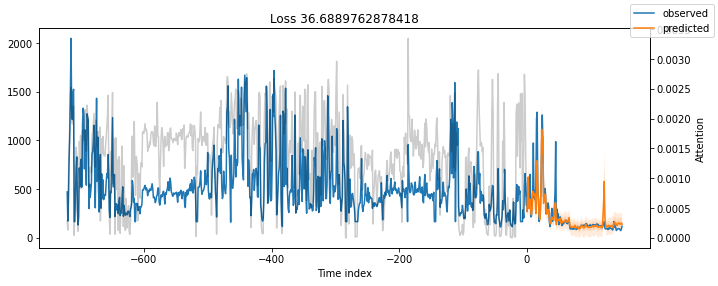

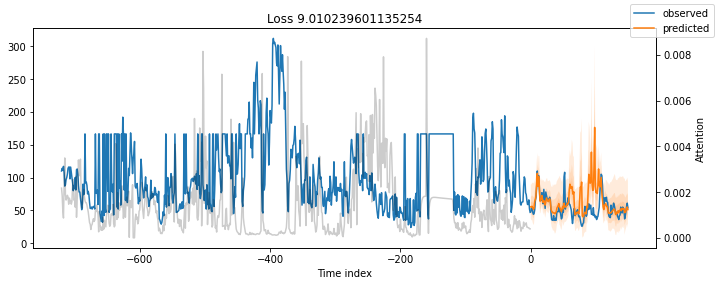

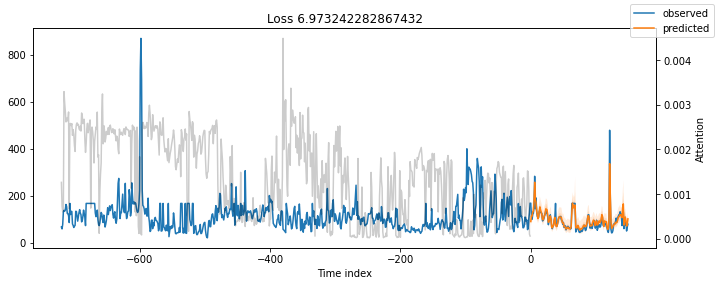

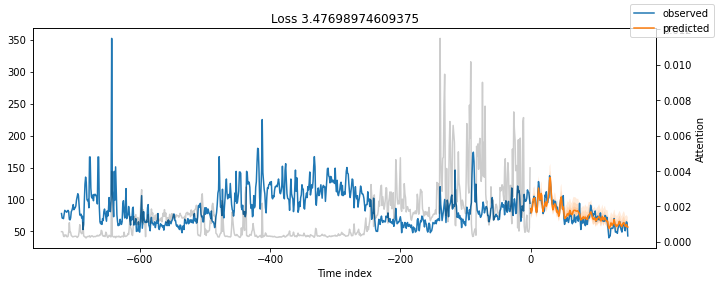

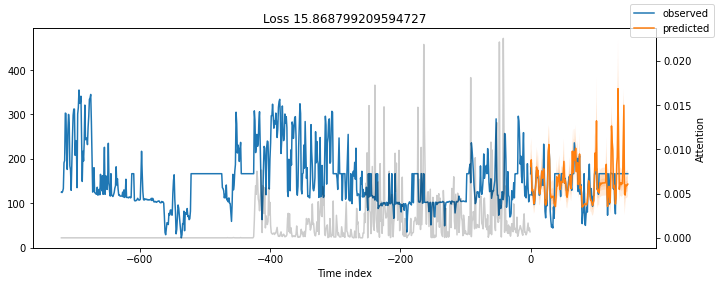

In [74]:
for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,ax=ax)

In [75]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="quantiles", return_x=True)

In [76]:
#for idx in range(10):  # plot 10 examples
    #best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

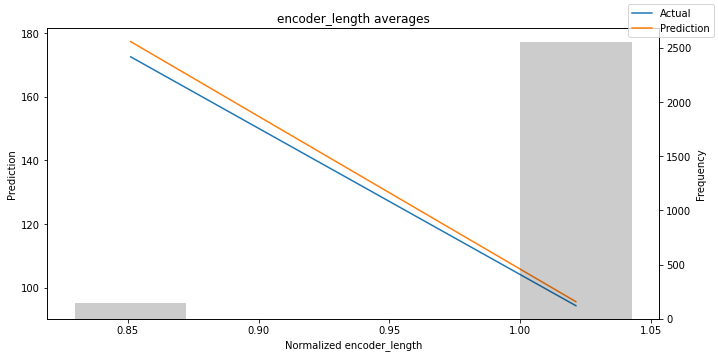

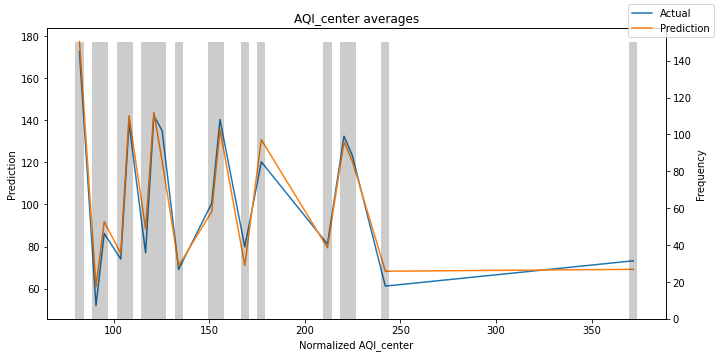

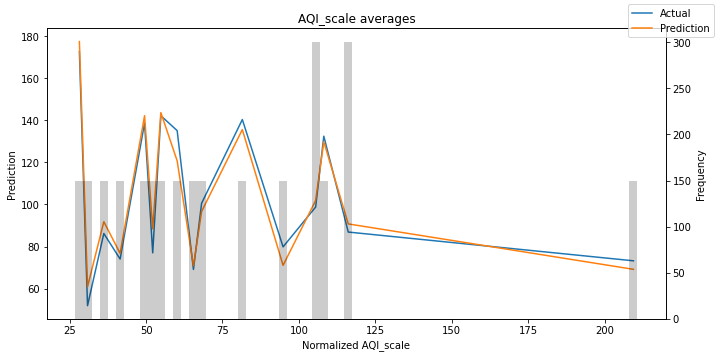

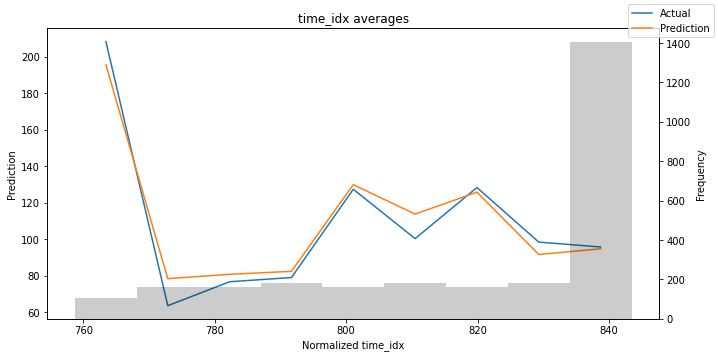

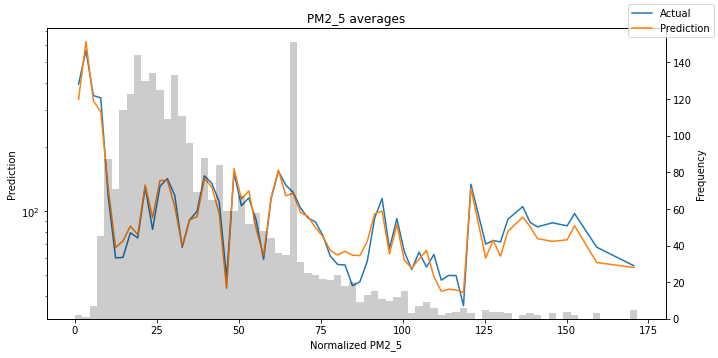

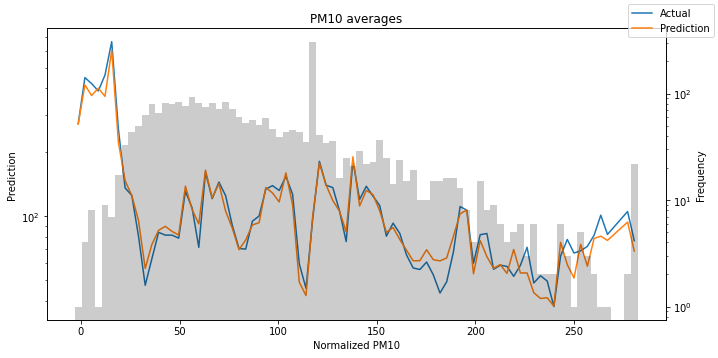

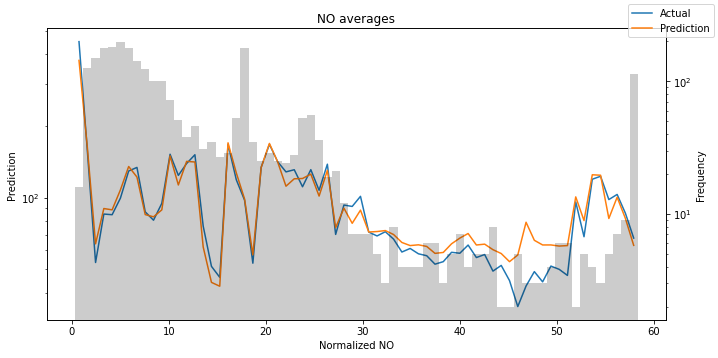

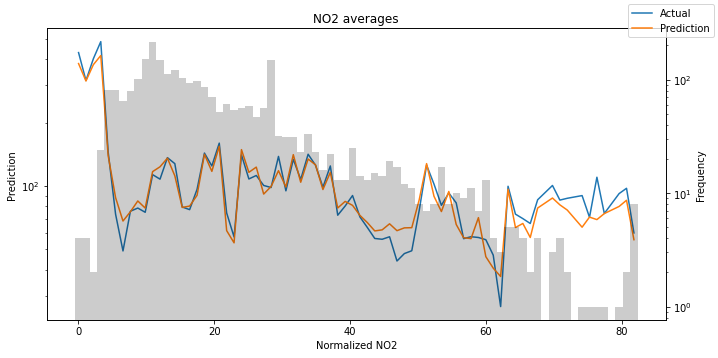

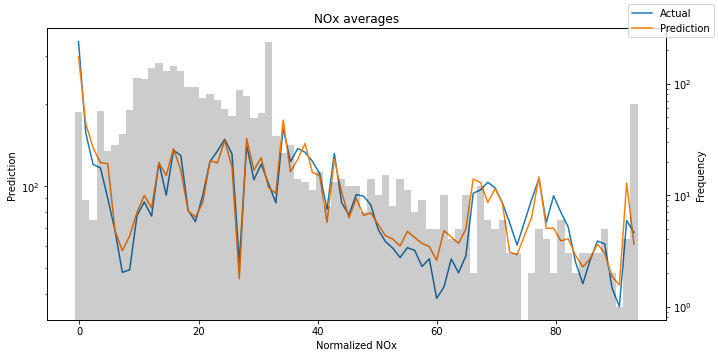

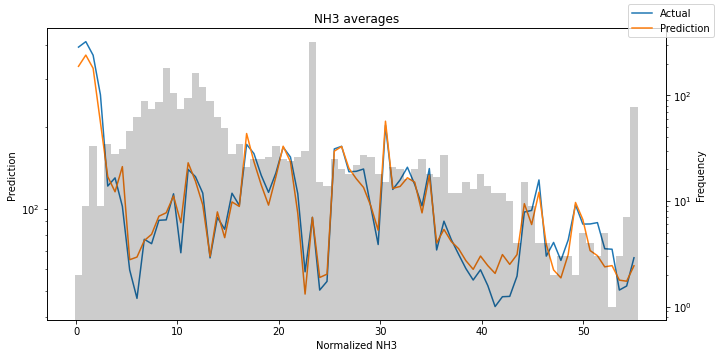

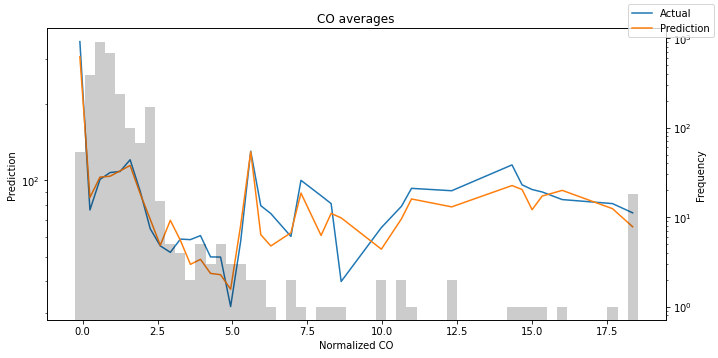

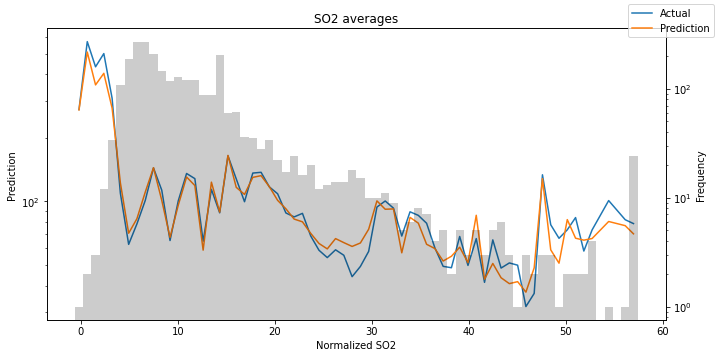

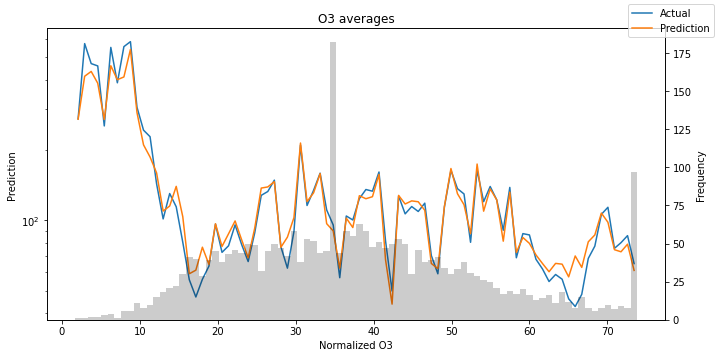

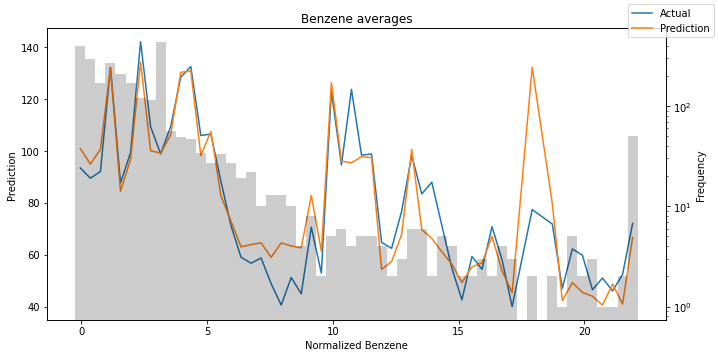

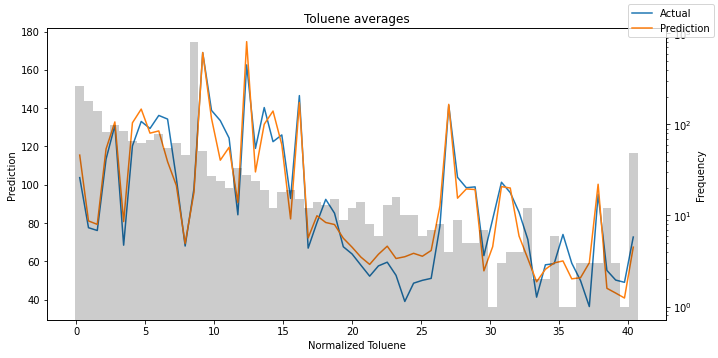

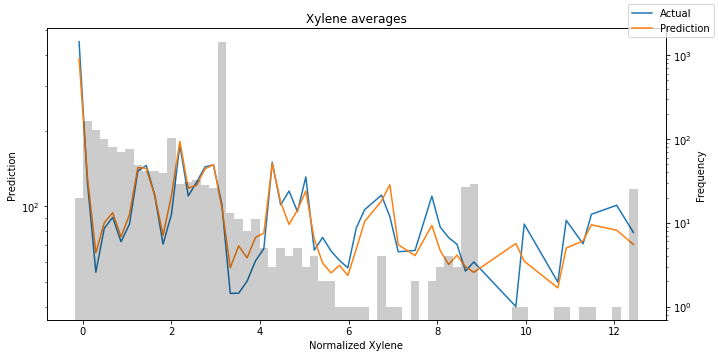

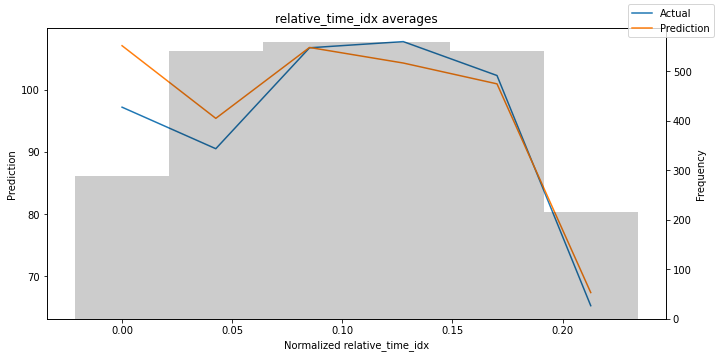

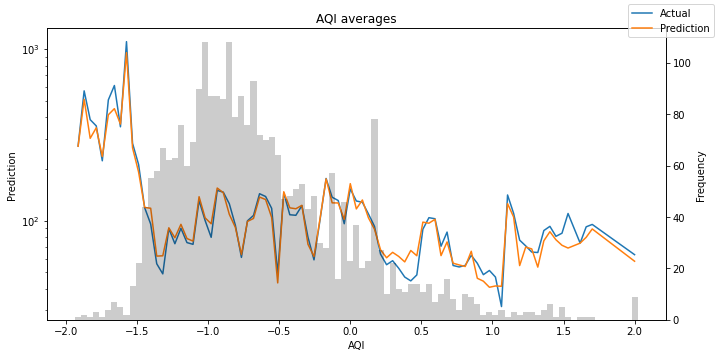

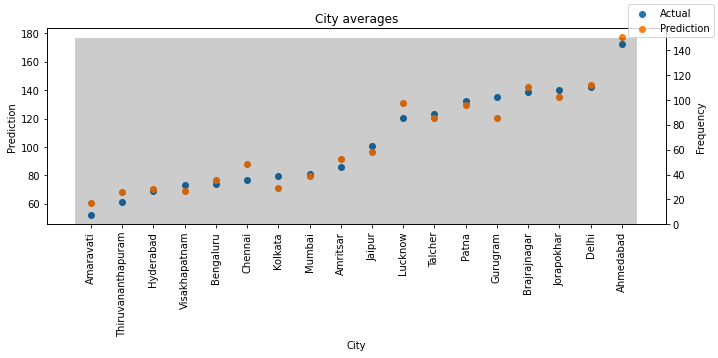

In [77]:
predictions, x= best_tft.predict(val_dataloader,mode ="prediction" ,return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

Forecasting Data for Ahmedabad

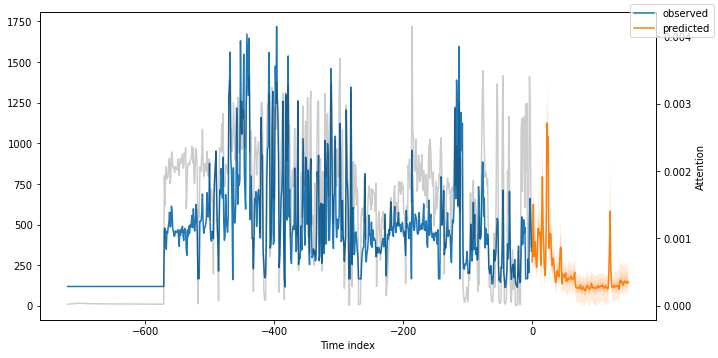

In [78]:

encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
#decoder_data["time_idx"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month


Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days
#decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
#decoder_data["month"] = decoder_data.Date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query(" City == 'Ahmedabad'")#Change the city here
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax);

Forecasting Data for Chennai

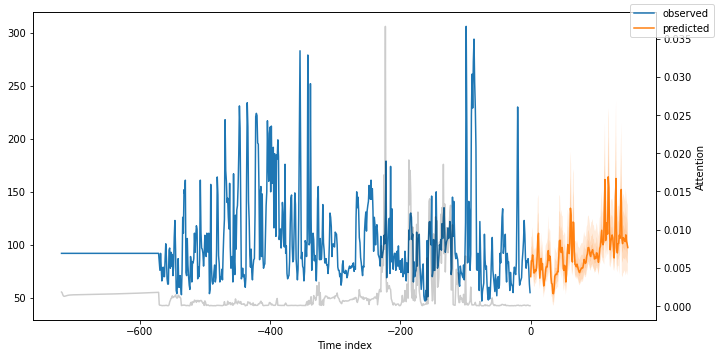

In [79]:
# select last 24 days from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the data
# in a real world dataset, 
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(Date=lambda x: x.Date + pd.offsets.DateOffset(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
#decoder_data["time_idx"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month


Date1 = decoder_data['Date'].min()
decoder_data["time_idx"] = decoder_data['Date'] - Date1
decoder_data["time_idx"] = decoder_data["time_idx"].dt.days
#decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
#decoder_data["month"] = decoder_data.Date.dt.month.astype(str).astype("category")  # categories have be strings
# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data1=new_prediction_data.query(" City == 'Chennai'")#Change the city here
new_raw_predictions1, new_x1 = best_tft.predict(new_prediction_data1, mode="raw", return_x=True)
best_tft.plot_prediction(new_x1, new_raw_predictions1, idx=0, show_future_observed=False, ax=ax);

In [80]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
x1=(((actuals - predictions).abs())/actuals.abs())
x1.mean()

tensor(0.1448)

In [81]:
#Mean average absolute error
m1=(predictions - actuals).abs()
m1.mean()

tensor(14.9041)

In [82]:
#SMAPE -  Symmetric mean absolute percentage
s1=2*(actuals - predictions).abs() / (actuals.abs() + predictions.abs()+ 1e-8)
s1.mean()

tensor(0.1337)

In [83]:
#RMSE
r1=(predictions - actuals)**2
r1
r1=r1.mean()
r1=r1.sqrt()
accuracy = 1.96*r1
print(r1)
print(accuracy)

tensor(33.4251)
tensor(65.5132)


In [84]:
import sklearn
mape=sklearn.metrics.mean_absolute_percentage_error(actuals, predictions)
print("MAPE:", mape)

MAPE: 0.1447617


In [85]:
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(actuals, predictions, squared=False)
print("RMSE:",rms)

RMSE: 24.676006
